<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Trabajo práctico 2

## Alumno
Denardi, Fabricio

## Cohorte
15-2024

# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer

from google.colab import drive
import os
import time

In [19]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  cuda
Torch version:  2.5.0+cu121


In [20]:

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


In [21]:
class PositionalEncodingLearned(nn.Module):

    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x+self.pos_embedding

# Transformer Encoder

In [22]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first=True):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False, batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

In [23]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size,  embed_dim, num_heads, ff_dim,
                 num_layers, dropout, in_channels=3, num_classes=10,batch_first = True):
        super(VisionTransformer, self).__init__()

        # 1. Generar embedding de los patch
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # 2. Definir Positional Encoding
        num_patches = (img_size//patch_size)**2
        self.positional_encoding = PositionalEncodingLearned(num_patches, embed_dim)

        # 3. Aplicar el  Transformer Encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout,batch_first)

        # 4. Fully Connected final
        self.output = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)

        x = x[:, 0]
        x = self.output(x)

        return x

# CIFAR10

In [24]:

# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Explicación de los Dataugmentations elegidos
Fui probando diferentes técnica de agumentation, siendo estas las que considere mejor para este problema:
### Horizontal Flip
Algunas imagenes de CiFAR 10 son simétricas, como es el caso de los autos y los aviones, la idea es que el modelo aprenda sin importar la orientación.

### Random Crop con Padding
Ayuda a que el modelo generalice mejor los objetos que están fuera de encuadre. Es decir a que sea invariante a la posición del objeto.


### Random Rotation
Es útil para animales o vehículos, los cuales pueden estar inclinados o girados según la imagen.

### Color Jitter
Ayuda a reconocer objetos y características claves de este, sin importar la iluminación o color específico.

###  Random Erasing
Ayuda a simular la oclusión parcial de un objeto.

### Random resize crop
Simula variaciones de tamaño y posición del objeto.

In [25]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelo

# Vision Transformer
Model

|               | ViT-Base | ViT-Large | ViT-Huge |
|---------------|----------|-----------|----------|
| **Layers**    | 12       | 24        | 32       |
| **Hidden size D** | 768  | 1024      | 1280     |
| **MLP size**  | 3072     | 4096      | 5120     |
| **Heads**     | 12       | 16        | 16       |
| **Params**    | 86M      | 307M      | 632M     |


De las 3 "versones" del modelo, decidí entrenar solamente los 2 primeros, dada la limtación de recursos que tengo con Colab.

In [26]:
experiments = []

experiment_base = {
    "name":  "ViT-Base",
    "img_size" :     32 ,
    "patch_size" :  4,
    "embed_dim" :   144 ,
    "num_heads" :    12,
    "ff_dim"  :     768 ,
    "num_layers":   12 ,
    "dropout"  :    0.1 ,
    "batch_first" : True
}


experiment_large = {
    "name":  "	ViT-Large",
    "img_size" :     32 ,
    "patch_size" :  4,
    "embed_dim" :   256 ,
    "num_heads" :    16,
    "ff_dim"  :      1024,
    "num_layers":   24 ,
    "dropout"  :    0.1 ,
    "batch_first" : True
}
experiments.append(experiment_large)
experiments.append(experiment_base)

In [27]:
num_epochs = 10

In [28]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()

In [29]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1




In [30]:

def visualize_classification(model, data_loader, class_names, title, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(title, fontsize=16)  # Agrega un título a la figura

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return




In [31]:
train_dataset.data[0].shape

(32, 32, 3)

In [32]:
class_names = train_dataset.classes

In [33]:
print(f'Las clases del dataset son:{class_names}')

Las clases del dataset son:['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


************************************************
************************************************
	ViT-Large
************************************************
************************************************






/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


------------------------------------------------
Arquitectura
------------------------------------------------
VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (positional_encoding): PositionalEncodingLearned()
  (transformer_encoder): TransformerEncoder(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-23): 24 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=False)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inpl

  0%|          | 0/98 [00:00<?, ?it/s]W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125] WON'T CONVERT forward <ipython-input-23-d8169ae097f3> line 19 
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125] due to: 
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125] Traceback (most recent call last):
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/output_graph.py", line 1446, in _call_user_compiler
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125]     compiled_fn = compiler_fn(gm, self.example_inputs())
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/repro/after_dynamo.py", line 129, in __call__
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125]     compiled_gm = compiler_fn(gm, example_inputs)
W1102 14:56:22.566000 30482 torch/_dynamo/convert_frame.py:1125]   File





------------------------------------------------
Evaluación
------------------------------------------------
Accuracy: 0.28
Precision: 0.26
Recall: 0.28
F1 score: 0.25




------------------------------------------------
Predicciones
------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


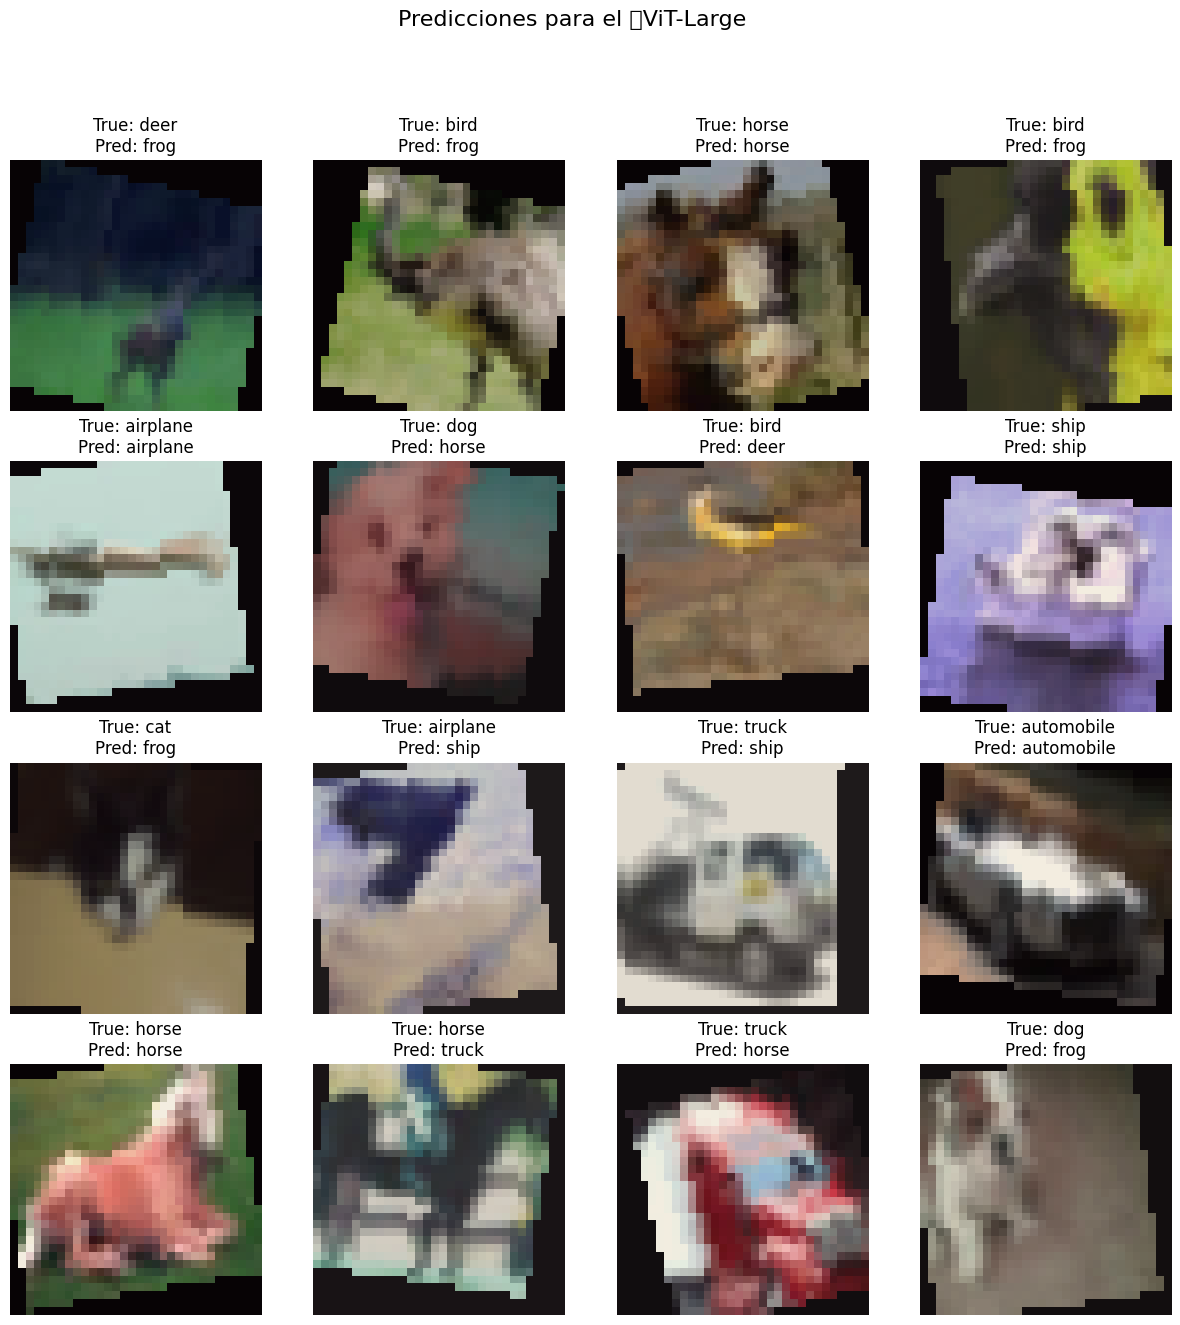

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


************************************************
************************************************
ViT-Base
************************************************
************************************************




------------------------------------------------
Arquitectura
------------------------------------------------
VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(3, 144, kernel_size=(4, 4), stride=(4, 4))
  )
  (positional_encoding): PositionalEncodingLearned()
  (transformer_encoder): TransformerEncoder(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=False)
          )
          (linear1): Linear(in_features=144, out_features=768, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=768, out_featur

100%|██████████| 20/20 [00:13<00:00,  1.54it/s]






------------------------------------------------
Evaluación
------------------------------------------------
Accuracy: 0.36
Precision: 0.35
Recall: 0.36
F1 score: 0.35




------------------------------------------------
Predicciones
------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]


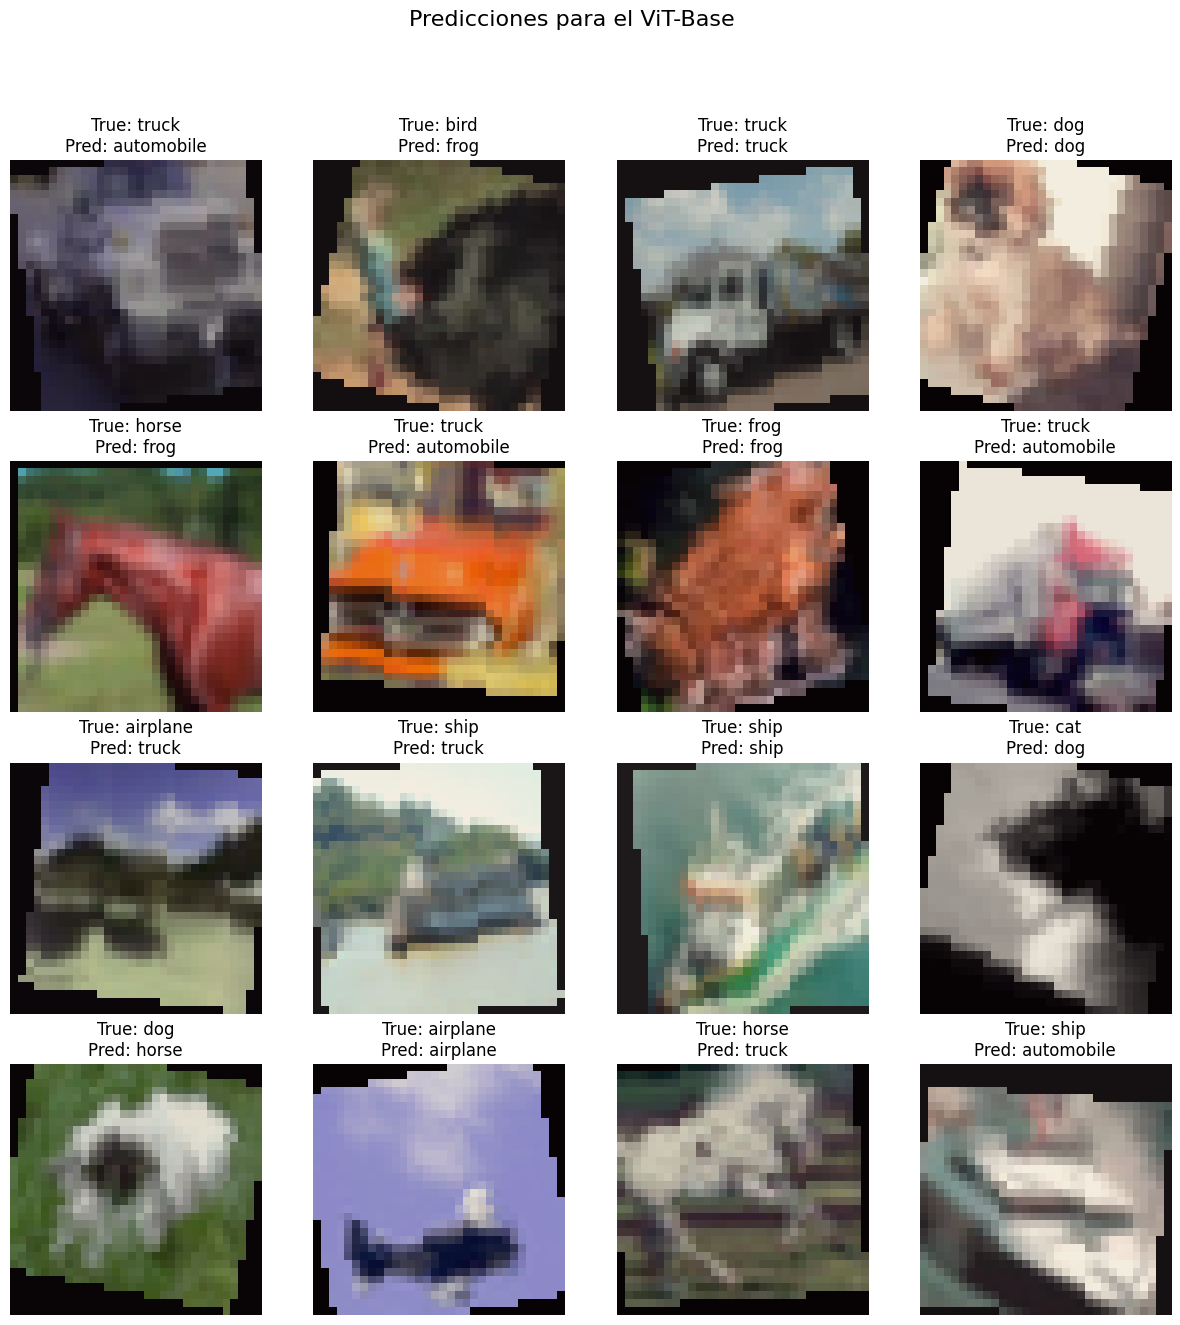

In [34]:
for experiment in experiments:
  print("************************************************")
  print("************************************************")
  print(f'{experiment["name"]}')
  print("************************************************")
  print("************************************************")
  print("\n")
  print("\n")


  model = VisionTransformer(
      img_size=     experiment["img_size"] ,
      patch_size=  experiment["patch_size"] ,
      embed_dim=    experiment["embed_dim"]  ,
      num_heads=     experiment["num_heads"] ,
      ff_dim=        experiment["ff_dim"] ,
      num_layers=   experiment["num_layers"]  ,
      dropout=      experiment["dropout"]  ,
      batch_first= experiment["batch_first"]
  ).to(device)

  # Definimos funciones de loss y optimizador
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr=3e-4)
  scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

  #model = model.to(device)

  print("------------------------------------------------")
  print(f'Arquitectura')
  print("------------------------------------------------")

  print(model)
  print("\n")
  try:
      model = torch.compile(model)
  except Exception as e:
      print("Se produjo error durante la compilación:", e)

  print("\n")
  print("\n")
  print("------------------------------------------------")
  print(f'Entrenamiento')
  print("------------------------------------------------")

  print("Número de parámetros : {:.2f} millones".format(count_parameters(model)))

  trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

  for epoch in range(num_epochs):

      trainer.train_model(use_amp=True)

      scheduler.step()


  accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

  print("\n")
  print("\n")
  print("------------------------------------------------")
  print(f'Evaluación')
  print("------------------------------------------------")

  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 score: {f1:.2f}')



  print("\n")
  print("\n")
  print("------------------------------------------------")
  print(f'Predicciones')
  print("------------------------------------------------")


  title = f'Predicciones para el {experiment["name"]}'

  visualize_classification(model, test_loader, class_names, title, num_images=16)
  plt.show()


# Conclusiones
1. Como mencioné en el TP anterior, para un correcto fine tunning y elección de hiperparamétros en un entorno productivo o para trabajos de mayor envergadura, es necesario recurrir a técnicas de Cross Validation o a framweorks como Optuna.

2. El uso de dataaugmentation en los problemas de visión por computudora es clave. Permite a partir de un dataset limitado, obtener variantes y evitar el overfitting.

3. La performance lograda no fue la esperada. Considero que puede deberse a:
  - Limitación de recursos.
  - Se podría haber entrenado más épocas
  - Agregar más capas fully conected al final del modelo, para mejorar la interacción de características.

4. Estuvimos trabajando en este TP con el modelo más simple de Vision Transformer, se podrían apicar modelos más complejos para mejorar la performance.

5. Aunque no lo dejé plasmado para hacer más legible la notebook, puse un patchsize de 8 en una de mis pruebas, y el modelo no aprendió. Esto puede deberse a que las imágenes de CIFAR 10 son muy pequeñas (32x32), por lo que quedaban muy pocos patches, perdiendo características locales.

6. Contrariamente a la intuición, el modelo más simple me performó (levemente) mejor. Esto puede deberse a un sobreajuste del modelo más complejo, a la falta de datos, vanish gradient entre otros motivos. Por eso, como mencioné en la conclusión 1, es importante usar una buena técnica de fine tunning y elección de hiperparámetros.

7. Siendo 10 clases, la heurística (tirar un random) es del 10%, y estamos teniendo aproximadamente el 25~35%. La métrica considero que es mala, aunque mejor que la heurística.